In [1]:
import os
#os.environ["JAX_CACHE_DIR"] = "/cluster/scratch/mpundir/jax-cache"
os.environ["JAX_PLATFORM"] = "cpu"

import jax
jax.config.update("jax_enable_x64", True)  # use double-precision
jax.config.update("jax_persistent_cache_min_compile_time_secs", 0)
jax.config.update("jax_platforms", "cpu")

import jax.numpy as jnp
import jax.experimental.sparse as jsp

import sparsejac
from petsc4py import PETSc


import numpy as np
import matplotlib.pyplot as plt

from femsolver.jax_utils import auto_vmap, vmap
from femsolver.quadrature import quad_tri3, shape_fn_tri3
from femsolver.operator import FemOperator

import cmcrameri.cm as cmc

In this tutorial, we will solve a nonlinear elasticity problem using the FEM solver. We consider a Neo-Hookean material model for which the strain energy density is given by:

$$
W = \frac{1}{2} \mu (I_1 - 3) + \frac{1}{2} \lambda \log^2(J)
$$

where $\mu$ and $\lambda$ are the Lame constants, $I_1$ is the first invariant of the right Cauchy-Green deformation tensor, and $J$ is the determinant of the deformation gradient.

The stress is given by:

$$
\sigma = \frac{\partial W}{\partial C} = \mu (C - I) + \lambda \log(J) \frac{C}{J}
$$

where $C$ is the right Cauchy-Green deformation tensor.

The deformation gradient is given by:

$$
F = \frac{\partial x}{\partial X}
$$

Which is given by:

$$
F = \nabla u + \boldsymbol{I}

$$



In [2]:
# ------------- Neo-Hookean Material Model -------------------
def neo_hookean_energy(F, mu=1.0, lam=1.0):
    J = jnp.linalg.det(F)
    C = F.T @ F
    I1 = jnp.trace(C)
    energy = 0.5 * mu * (I1 - 2) - mu * jnp.log(J) + 0.5 * lam * (jnp.log(J)) ** 2
    return energy


neo_hookean_stress = jax.jacrev(neo_hookean_energy)

def compute_energy_nl(u_grad, mu=1.0, lmbda=1.0):
    F = u_grad + jnp.eye(2)
    return neo_hookean_energy(F, mu, lmbda)


def total_energy(u_flat, coords, elements, fem):
    u = u_flat.reshape(-1, 2)
    u_cell = u[elements]
    x_cell = coords[elements]
    return jnp.sum(fem.integrate(u_cell, x_cell))


compute_internal = jax.jacrev(total_energy)

In [3]:
# --- Mesh generation (reuse from linear example) ---
def generate_unit_square_mesh_tri(nx, ny):
    x = jnp.linspace(0, 1, nx + 1)
    y = jnp.linspace(0, 1, ny + 1)
    xv, yv = jnp.meshgrid(x, y, indexing="ij")
    coords = jnp.stack([xv.ravel(), yv.ravel()], axis=-1)

    def node_id(i, j):
        return i * (ny + 1) + j

    elements = []
    for i in range(nx):
        for j in range(ny):
            n0 = node_id(i, j)
            n1 = node_id(i + 1, j)
            n2 = node_id(i, j + 1)
            n3 = node_id(i + 1, j + 1)
            elements.append([n0, n1, n3])
            elements.append([n0, n3, n2])
    return coords, jnp.array(elements)


def create_sparse_structure(elements, nstate, K_shape):
    # elements: (num_elements, nodes_per_element)
    elements = jnp.array(elements)
    num_elements, nodes_per_element = elements.shape

    # Compute all (i, j, k, l) combinations for each element
    i_idx = jnp.repeat(
        elements, nodes_per_element, axis=1
    )  # (num_elements, nodes_per_element^2)
    j_idx = jnp.tile(
        elements, (1, nodes_per_element)
    )  # (num_elements, nodes_per_element^2)

    # Expand for nstate
    k_idx = jnp.arange(nstate, dtype=jnp.int32)
    l_idx = jnp.arange(nstate, dtype=jnp.int32)
    k_idx, l_idx = jnp.meshgrid(k_idx, l_idx, indexing="ij")
    k_idx = k_idx.flatten()
    l_idx = l_idx.flatten()

    # For each element, get all (row, col) indices
    def element_indices(i, j):
        row = nstate * i + k_idx
        col = nstate * j + l_idx
        return row, col

    # Vectorize over all (i, j) pairs for all elements
    row_idx, col_idx = jax.vmap(element_indices)(i_idx.flatten(), j_idx.flatten())

    # Flatten and clip to matrix size
    row_idx = row_idx.flatten()
    col_idx = col_idx.flatten()
    mask = (row_idx < K_shape[0]) & (col_idx < K_shape[1])
    row_idx = row_idx[mask]
    col_idx = col_idx[mask]

    # Create the sparse structure
    indices = np.unique(np.vstack((row_idx, col_idx)).T, axis=0)
    return np.ones(indices.shape[0], dtype=jnp.int32), indices.astype(np.int32)

In [4]:
# ------------- Mesh (simple triangle mesh on unit square) ----------------
nodes, elements = generate_unit_square_mesh_tri(10, 10)

n_nodes = nodes.shape[0]


n_dofs_per_node = 2
n_dofs = n_dofs_per_node * n_nodes


data, indices = create_sparse_structure(elements, n_dofs_per_node, (n_dofs, n_dofs))

sparsity_pattern = jsp.BCOO((data, indices), shape=(n_dofs, n_dofs))

compute_stiffness_sparse = sparsejac.jacfwd(compute_internal, sparsity=sparsity_pattern)

In [18]:
def apply_dirichlet_boundary_conditions(K_sparse_data, indices, fixed_dofs):
    K_bc_data = K_sparse_data.copy()
    for dof in fixed_dofs:
        indexes = jnp.where(indices[:, 0] == dof)[0]
        for idx in indexes:
            K_bc_data = K_bc_data.at[idx].set(0)

        idx = jnp.where(jnp.all(indices == jnp.array([dof, dof]), axis=1))[0]
        K_bc_data = K_bc_data.at[idx].set(1)

    return K_bc_data

In [19]:

# ------------- Newton-Raphson Solver -------------------
def newton_solver(
    fem,
    nodes,
    elements,
    fixed_dofs,
    u_target_flat,
    n_steps,
    tol=1e-8,
    max_iter=20,
):

    du_total = u_target_flat / n_steps  # displacement increment
    u = jnp.zeros(n_nodes * n_dofs_per_node)
    fext = jnp.zeros(n_nodes * n_dofs_per_node)

    A = PETSc.Mat()
    A.createAIJ(size=(n_dofs, n_dofs))

    b = A.createVecLeft()
    du = A.createVecRight()

    for step in range(n_steps):
        print(f"Step {step+1}/{n_steps}")
        u = u.at[fixed_dofs].set((step + 1) * du_total[fixed_dofs])

        #fext = fext.at[applied_dofs[dir]].set(applied_loading[step])
        fint = compute_internal(u, nodes, elements, fem)
        K_sparse = compute_stiffness_sparse(u, nodes, elements, fem)
                    
        iiter = 0
        norm_res = 1.

        while norm_res > tol and iiter < max_iter:
            residual = fext - fint
            residual = residual.at[fixed_dofs].set(0)

            K_bc_data = apply_dirichlet_boundary_conditions(
                K_sparse_data=K_sparse.data,
                indices=indices,
                fixed_dofs=fixed_dofs,
            )
    
            A.zeroEntries()
            for index, value in zip(indices, K_bc_data):
                row, col = index
                A.setValue(row, col, value)
            A.assemble()

            ksp = PETSc.KSP().create()
            ksp.setOperators(A)

            b.zeroEntries()
            b.setArray(residual)

            ksp.setConvergenceHistory()
            ksp.getPC().setType("none")
            du.zeroEntries()
            ksp.solve(b, du)

            ksp.destroy()

            u = u.at[:].add(du.getArray())

            fint = compute_internal(u, nodes, elements, fem)
            K_sparse = compute_stiffness_sparse(u, nodes, elements, fem)

            residual = fext - fint
            residual = residual.at[fixed_dofs].set(0)

            norm_res = jnp.linalg.norm(residual)
            print(f"  Residual: {norm_res:.2e}")

            iiter += 1
    
    return u

In [20]:
# ------------- Apply Dirichlet BCs ---
left_nodes = jnp.where(jnp.isclose(nodes[:, 0], 0.0))[0]
right_nodes = jnp.where(jnp.isclose(nodes[:, 0], 1.0))[0]
fixed_dofs = jnp.concatenate(
    [
        2 * left_nodes,
        2 * left_nodes + 1,
        2 * right_nodes,
    ]
)


u_target = jnp.zeros(n_dofs).at[2 * right_nodes].set(0.4)
#u_target = u0.at[loaded_nodes, 0].set(0.1)  # 0.2 rightward displacement
u_target_flat = u_target.flatten()

# ------------- Solve -------------------
# fem = FemOperator(tri3_quadrature, shape_fn_tri3, neo_hookean)
fem = FemOperator(
    compute_quads=quad_tri3,
    compute_shape_fn=shape_fn_tri3,
    compute_energy=compute_energy_nl,
)

In [21]:
K_sparse = compute_stiffness_sparse(u_target_flat, nodes, elements, fem)

In [22]:
u_final_flat = newton_solver(
    fem, nodes, elements, fixed_dofs, u_target_flat, n_steps=50
)

Step 1/50


  Residual: 3.69e-03
  Residual: 9.98e-06
  Residual: 1.25e-10
Step 2/50
  Residual: 3.59e-03
  Residual: 9.45e-06
  Residual: 1.14e-10
Step 3/50
  Residual: 3.50e-03
  Residual: 8.94e-06
  Residual: 1.06e-10
Step 4/50
  Residual: 3.41e-03
  Residual: 8.47e-06
  Residual: 1.00e-10
Step 5/50
  Residual: 3.32e-03
  Residual: 8.03e-06
  Residual: 9.18e-11
Step 6/50
  Residual: 3.24e-03
  Residual: 7.61e-06
  Residual: 8.42e-11
Step 7/50
  Residual: 3.16e-03
  Residual: 7.22e-06
  Residual: 8.03e-11
Step 8/50
  Residual: 3.08e-03
  Residual: 6.85e-06
  Residual: 7.03e-11
Step 9/50
  Residual: 3.00e-03
  Residual: 6.50e-06
  Residual: 6.84e-11
Step 10/50
  Residual: 2.93e-03
  Residual: 6.17e-06
  Residual: 6.57e-11
Step 11/50
  Residual: 2.86e-03
  Residual: 5.85e-06
  Residual: 6.01e-11
Step 12/50
  Residual: 2.79e-03
  Residual: 5.56e-06
  Residual: 5.59e-11
Step 13/50
  Residual: 2.72e-03
  Residual: 5.28e-06
  Residual: 5.53e-11
Step 14/50
  Residual: 2.66e-03
  Residual: 5.01e-06
  Re

In [11]:
# --- Compute von Mises stress ---
def von_mises_stress(stress):
    s_xx, s_yy = stress[0, 0], stress[1, 1]
    s_xy = stress[0, 1]
    return jnp.sqrt(s_xx**2 - s_xx * s_yy + s_yy**2 + 3 * s_xy**2)


# --- Compute von Mises stress per element ---
def compute_element_stress(coords, u, elements, fem):
    u_cells = u.reshape(-1,  n_dofs_per_node)[elements]
    coords_cells = coords[elements]

    def element_von_mises(u_e, x_e):
        qp, _ = quad_tri3()
        xi = qp[0]  # just take one point per element
        grad_u = fem.gradient(xi, u_e, x_e)
        F = grad_u + jnp.eye(2)
        sigma = neo_hookean_stress(F)
        return von_mises_stress(sigma)

    return jax.vmap(element_von_mises)(u_cells, coords_cells)


# --- Visualization ---
from femsolver.plotting import STYLE_PATH

def plot_displacement_and_stress(coords, u, elements, stress, scale=1.0):
    displaced = coords + scale * u
    tri_elements = elements

    plt.style.use(STYLE_PATH)
    plt.figure(figsize=(5, 4))
    plt.tripcolor(
        displaced[:, 0],
        displaced[:, 1],
        tri_elements,
        facecolors=stress,
        shading="flat",
        cmap=cmc.managua_r,
        edgecolors="black",
    )
    plt.colorbar(label="Von Mises Stress")
    plt.title("Von Mises Stress on Deformed Mesh")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.axis("equal")
    plt.show()


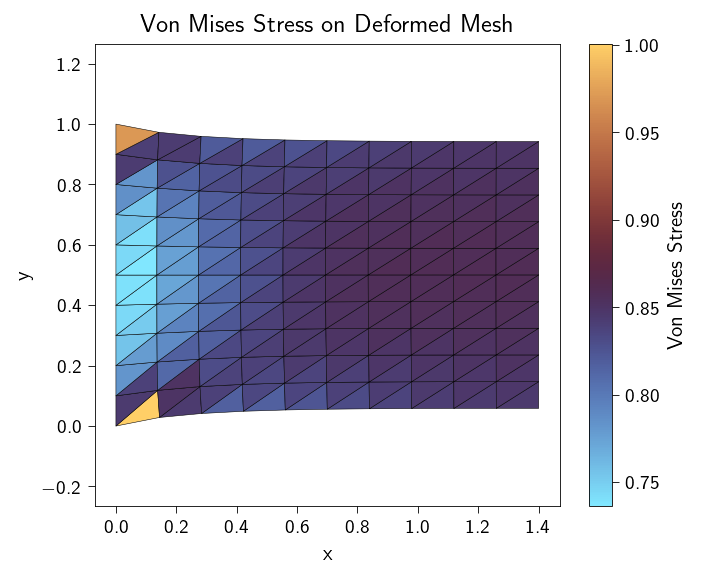

In [12]:
# ------------- Postprocessing -------------------
u_final = u_final_flat.reshape(-1, 2)

stress_vm = compute_element_stress(nodes, u_final, elements, fem)

# --- Plot the displacement and stress ---
plot_displacement_and_stress(nodes, u_final, elements, stress_vm)